# A. Replicating the Original Paper

Here we try replicating the original paper [1] while introducing the following changes:

1. Also testing out the usage of the LAV-DF dataset.
2. Swapping out the EfficientNet-B3 backbone with ResNet-18.

## A1. Mount and Setup Drive

In [ ]:
from google.colab import drive
import os
import glob
import random
import numpy as np
import pandas as pd

drive.mount('/content/drive')
DATA_ROOT = '/content/drive/My Drive/Deep Fake Dataset'

try:
    os.chdir(DATA_ROOT)
    print(f"Working Directory: {os.getcwd()}")
except Exception as e:
    print(f"Error: {e}")

# Define paths for saving processed data
# Uncomment this block for the DeepFake dataset
PROCESSED_ROOT = os.path.join(DATA_ROOT, 'processed_faces')
# os.makedirs(os.path.join(PROCESSED_ROOT, 'train', 'real'), exist_ok=True)
# os.makedirs(os.path.join(PROCESSED_ROOT, 'train', 'fake'), exist_ok=True)
# os.makedirs(os.path.join(PROCESSED_ROOT, 'val', 'real'), exist_ok=True)
# os.makedirs(os.path.join(PROCESSED_ROOT, 'val', 'fake'), exist_ok=True)

# Uncomment this block for the LAV-DF dataset
PROCESSED_ROOT = os.path.join(DATA_ROOT, 'processed_faces_av')

# 1. Locate Original Video Files
# real_videos = glob.glob(os.path.join(DATA_ROOT, 'original_sequences/youtube/c23/videos', '*.mp4'))
# fake_videos = glob.glob(os.path.join(DATA_ROOT, 'manipulated_sequences/Deepfakes/c23/videos', '*.mp4'))
# print(real_videos[:10])

def add_base_relative_path(filename):
    return os.path.join(DATA_ROOT, "LAV-DF", filename)

df = pd.read_csv(os.path.join(
    DATA_ROOT,
    'predictions_from_mlready_arrays',
    'mlready_predictions_audio_FINAL.csv'
), header=None)
real_videos = df[df[8] == 'real'][3].tolist()
real_videos = list(map(add_base_relative_path, real_videos))
fake_videos = df[df[8] == 'fake'][3].tolist()
fake_videos = list(map(add_base_relative_path, fake_videos))
print(real_videos[:10])

# 2. Labels: 0=Real, 1=Fake
all_videos = [(p, 0) for p in real_videos] + [(p, 1) for p in fake_videos]
random.shuffle(all_videos)


# 3. Split by VIDEO
split = int(0.5 * len(all_videos))
train_videos = all_videos[:split]
val_videos   = all_videos[split:]

print(f"Dataset Split: {len(train_videos)} Training Videos, {len(val_videos)} Validation Videos")

Mounted at /content/drive
Working Directory: /content/drive/My Drive/Deep Fake Dataset
['/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/014471.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/013733.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/034642.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/017940.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/025884.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/008394.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/021829.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/035137.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/008348.mp4', '/content/drive/My Drive/Deep Fake Dataset/LAV-DF/train/030660.mp4']
Dataset Split: 1984 Training Videos, 1984 Validation Videos


## A2. Record (for LAV-DF only) the train/eval split

Since with LAV-DF, we are training three models across different notebooks, we will need to record the splits here to avoid data leakage.

In [ ]:
import json
import os

# Create a dictionary to hold the video lists
video_data = {
    "train_videos": train_videos,
    "val_videos": val_videos
}

# Define the path for the JSON file
json_path = os.path.join(DATA_ROOT, 'video_splits.json')

# Write the data to the JSON file
with open(json_path, 'w') as f:
    json.dump(video_data, f, indent=4)

print(f"Video splits saved to: {json_path}")

Video splits saved to: /content/drive/My Drive/Deep Fake Dataset/video_splits.json


## A3. Extract Faces using YOLO

This block is only required to run once for each datasetm as it processes through the extracted frames and saves the faces in Google Drive. This block has been run. No need to run again.

In [ ]:
# import cv2
# from tqdm.auto import tqdm

# # Load YOLO
# net = cv2.dnn.readNetFromDarknet("face.cfg", "face.weights")

# def detect_face_yolo(frame):
#     h, w = frame.shape[:2]
#     blob = cv2.dnn.blobFromImage(frame, 1/255., (416,416), swapRB=True, crop=False)
#     net.setInput(blob)
#     outputs = net.forward(net.getUnconnectedOutLayersNames())
#     boxes = []
#     for output in outputs:
#         for det in output:
#             scores = det[5:]
#             confidence = det[4]
#             if confidence > 0.5:
#                 cx, cy, bw, bh = det[0:4] * np.array([w, h, w, h])
#                 x = int(cx - bw/2)
#                 y = int(cy - bh/2)
#                 boxes.append((x, y, int(bw), int(bh)))
#     return boxes

# def process_and_save(video_list, split_name):
#     print(f"Processing {split_name} set...")

#     for video_path, label in tqdm(video_list):
#         cap = cv2.VideoCapture(video_path)
#         if not cap.isOpened(): continue

#         # Paper: 2 frames per second
#         fps = cap.get(cv2.CAP_PROP_FPS)
#         if fps <= 0: fps = 25
#         interval = int(fps // 2)

#         vid_name = os.path.splitext(os.path.basename(video_path))[0]
#         # label_str = 'real' if label == 0 else 'fake'
#         # save_dir = os.path.join(PROCESSED_ROOT, split_name, label_str)
#         save_dir = os.path.join(PROCESSED_ROOT, split_name)

#         frame_idx = 0
#         saved_count = 0
#         max_frames_per_video = 10 # Cap frames to prevent disk overflow

#         while saved_count < max_frames_per_video:
#             ret, frame = cap.read()
#             if not ret: break

#             if frame_idx % interval == 0:
#                 boxes = detect_face_yolo(frame)
#                 if boxes:
#                     boxes = sorted(boxes, key=lambda b: b[2]*b[3], reverse=True)
#                     x, y, w, h = boxes[0]
#                     x, y = max(0, x), max(0, y)
#                     w = min(w, frame.shape[1] - x)
#                     h = min(h, frame.shape[0] - y)

#                     face = frame[y:y+h, x:x+w]
#                     if face.size > 0:
#                         # Paper: Resize to 224x224
#                         face = cv2.resize(face, (224, 224))

#                         # Save to disk
#                         save_path = os.path.join(save_dir, f"{vid_name}_{saved_count}.jpg")
#                         cv2.imwrite(save_path, face)
#                         saved_count += 1
#             frame_idx += 1
#         cap.release()

# # Run the Extraction
# # process_and_save(train_videos, 'train')
# # process_and_save(val_videos, 'val')
# process_and_save(all_videos, 'all')
# print("Preprocessing Complete! Images saved to disk.")

Processing all set...


  0%|          | 0/3968 [00:00<?, ?it/s]

Preprocessing Complete! Images saved to disk.


## A4. Define the Original CNN Model



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class DeepFakeHybridModel(nn.Module):
    def __init__(self):
        super(DeepFakeHybridModel, self).__init__()

        # 1. Base: EfficientNet-B3 [cite: 131]
        self.backbone = models.efficientnet_b3(pretrained=True)
        self.backbone.classifier = nn.Identity()

        # 2. Custom Layers (The "Head") [cite: 132-135]
        # EfficientNet-B3 output is 1536
        self.dense_512 = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.dense_128 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        # Final Softmax (2 classes)
        self.classifier = nn.Linear(128, 2)

    def forward(self, x):
        x = self.backbone(x)         # 1536
        feat_512 = self.dense_512(x) # 512 (For Ensemble)
        x = self.dense_128(feat_512)
        out = self.classifier(x)     # Classification (For Training)
        return out, feat_512

## A5. Train the CNN

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from tqdm.auto import tqdm
import os

# --- CONFIGURATION ---
CHECKPOINT_PATH = os.path.join(DATA_ROOT, 'trained_cnn', 'efficientnet_deepfake_v1_30epoch.pth')
LOAD_PRETRAINED = True  # Set to True to load from disk, False for fresh start
NUM_EPOCHS = 0          # Set to 0 to skip training (e.g., if just loading)
# ---------------------

# 1. Setup Data Loaders
train_tf = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# train_dir = "/content/processed_faces"
train_dir = "/content/drive/MyDrive/Deep Fake Dataset/processed_faces"
train_dataset = ImageFolder(train_dir, transform=train_tf)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. Setup Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeHybridModel().to(device)

# Logic to load or initialize blank
if LOAD_PRETRAINED and os.path.exists(CHECKPOINT_PATH):
    print(f"Loading weights from {CHECKPOINT_PATH}...")
    model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
    print("Model loaded successfully.")
else:
    if LOAD_PRETRAINED:
        print(f"Warning: File {CHECKPOINT_PATH} not found.")
    print("Initializing blank EfficientNet Hybrid Model...")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Training Loop
if NUM_EPOCHS > 0:
    print(f"Starting Stage 1 Training for {NUM_EPOCHS} epochs...")
    model.train()

    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(inputs) # Ignore features during training
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        print(f"Epoch {epoch+1} Avg Loss: {running_loss/len(train_loader):.4f}")

    print("CNN Training Complete.")
else:
    print("Skipping training (NUM_EPOCHS is 0). Model is ready for extraction.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading weights from /content/drive/My Drive/Deep Fake Dataset/trained_cnn/efficientnet_deepfake_v1_30epoch.pth...
Model loaded successfully.
Skipping training (NUM_EPOCHS is 0). Model is ready for extraction.


## A6. Evaluate the Model

Setting up evaluation on: /content/drive/My Drive/Deep Fake Dataset/processed_faces/val
Validation dataset size: 4000 images
Classes: ['fake', 'real']
Starting inference...


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]


--- Evaluation Results ---
Overall Accuracy: 0.9830

Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      1900
        real       0.98      0.98      0.98      2100

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



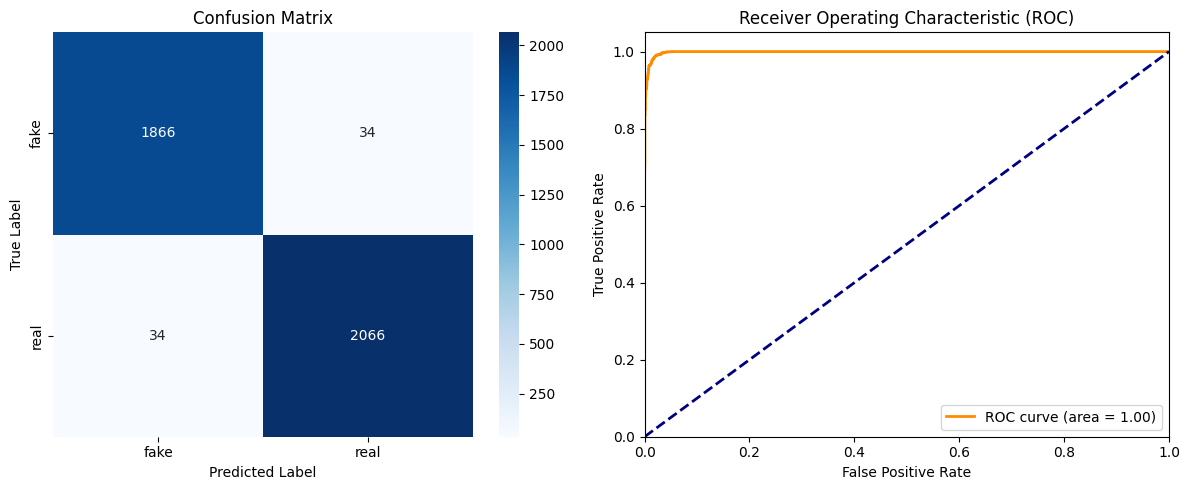

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURATION ---
# Ensure this matches the structure created in Snippet 1
VAL_DIR = os.path.join(DATA_ROOT, 'processed_faces', 'val')
BATCH_SIZE = 32
# ---------------------

print(f"Setting up evaluation on: {VAL_DIR}")

# 1. Setup Validation Loader
# We use the same normalization (train_tf) as defined in the previous block
if os.path.exists(VAL_DIR):
    val_dataset = ImageFolder(VAL_DIR, transform=train_tf)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle False for evaluation

    print(f"Validation dataset size: {len(val_dataset)} images")
    print(f"Classes: {val_dataset.classes}") # Should be ['fake', 'real'] or similar
else:
    print(f"Error: Validation directory {VAL_DIR} not found. Please ensure frame extraction ran correctly.")
    val_loader = None

# 2. Evaluation Loop
if val_loader:
    model.eval()  # Set model to evaluation mode

    y_true = []
    y_pred = []
    y_probs = []  # Store probabilities for ROC curve

    print("Starting inference...")
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device) # 0 or 1

            # Model returns (logits, features) - we only need logits here
            logits, _ = model(inputs)

            # Apply Softmax to get probabilities (for ROC)
            probs = torch.softmax(logits, dim=1)

            # Get predicted class (0 or 1)
            _, preds = torch.max(logits, 1)

            # Store results on CPU
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy()[:, 1]) # Probability of class 1 (Fake)

    # 3. Calculate Metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n--- Evaluation Results ---")
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Detailed classification report (Precision, Recall, F1)
    # Assuming class 0 = Real, 1 = Fake based on your Snippet 1 sorting
    target_names = val_dataset.classes
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # 4. Visualizations
    plt.figure(figsize=(12, 5))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

else:
    print("Skipping evaluation due to missing data.")

## A7. Save the Trained CNN

In [ ]:
import os
import torch

# Define save location
save_dir = os.path.join(DATA_ROOT, 'trained_cnn')
os.makedirs(save_dir, exist_ok=True)

# Define filename
model_name = "name-here"
save_path = os.path.join(save_dir, model_name)

# Save the model weights (state_dict is preferred over saving the whole object)
torch.save(model.state_dict(), save_path)

print(f"Model successfully saved to: {save_path}")

Model successfully saved to: /content/drive/My Drive/Deep Fake Dataset/trained_cnn/efficientnet_deepfake_v1_30epoch.pth


## A8. Train and Evaludate the Ensemble Methods

In [ ]:
import glob
import numpy as np
import os
from PIL import Image
from tqdm.auto import tqdm
import torch
import torchvision.transforms as T
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

def extract_features_from_disk(split_name, model):
    """
    Extracts 512-dim features from the Dense layer of the trained model.
    Groups frames by video to create a single feature vector per video.
    """
    model.eval()
    dataset_path = os.path.join(PROCESSED_ROOT, split_name)

    # Dictionary to group features by video: { 'video_name': [feat1, feat2...] }
    video_features = {}
    video_labels = {}

    # Get all jpgs recursively
    all_images = glob.glob(os.path.join(dataset_path, '*/*.jpg'))

    print(f"Extracting features from {len(all_images)} frames in {split_name} set...")

    # Must match the transforms used during training
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    with torch.no_grad():
        for img_path in tqdm(all_images):
            # 1. Parse Metadata from Filename
            # Path structure: .../train/real/video_name_frame0.jpg
            filename = os.path.basename(img_path)
            # Remove '_frameX.jpg' to recover the unique video ID
            vid_name = filename.rsplit('_', 1)[0]

            # Get label from parent folder name ('real' or 'fake')
            parent_folder = os.path.basename(os.path.dirname(img_path))
            label = 0 if parent_folder == 'real' else 1

            # 2. Load and Preprocess Image
            # .convert('RGB') ensures we don't crash on Alpha channels
            img = Image.open(img_path).convert('RGB')
            img_t = transform(img).unsqueeze(0).to(device)

            # 3. Hybrid Forward Pass
            # We ignore the first return (classification logits)
            # We capture the second return (the 512-dim embedding) [cite: 135]
            _, feat_512 = model(img_t)

            # Flatten to 1D array (512,)
            feat_np = feat_512.cpu().numpy().flatten()

            # 4. Group by Video
            if vid_name not in video_features:
                video_features[vid_name] = []
                video_labels[vid_name] = label

            video_features[vid_name].append(feat_np)

    # 5. Aggregate: Average all frame features to get one vector per video
    final_X = []
    final_y = []
    for vid, feats in video_features.items():
        # Mean of (N_frames, 512) -> (512,)
        avg_feat = np.mean(feats, axis=0)
        final_X.append(avg_feat)
        final_y.append(video_labels[vid])

    return np.array(final_X), np.array(final_y)

Starting Feature Extraction...
Extracting features from: /content/local_data/train


Processing train:   0%|          | 0/16000 [00:00<?, ?it/s]

Extracting features from: /content/local_data/val


Processing val:   0%|          | 0/4000 [00:00<?, ?it/s]


Feature Extraction Complete.
Training Vectors: (1600, 512) (Videos x 512)
Validation Vectors: (400, 512) (Videos x 512)

--- Individual Classifier Performance ---
SVM Accuracy: 98.50%
DT Accuracy: 99.00%
KNN Accuracy: 98.75%
NB Accuracy: 99.25%

--- Final Ensemble Performance ---
Ensemble Accuracy: 98.75%

Detailed Report:
              precision    recall  f1-score   support

        Real       0.98      1.00      0.99       210
        Fake       1.00      0.97      0.99       190

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



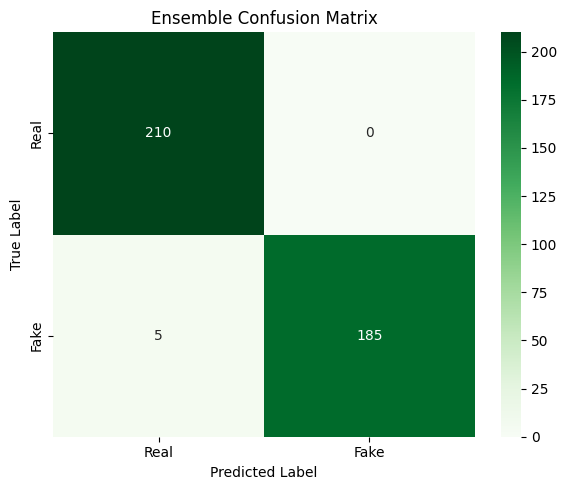

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- EXECUTION ---

# 1. Extract Features using the loaded/trained model
# Note: 'model' must be defined and loaded from the previous code block
print("Starting Feature Extraction...")
# Assuming 'extract_features_from_disk' or similar function is defined from previous blocks
# If using the ResNet function we just wrote, ensure you use that function name (e.g., extract_features)
X_train, y_train = extract_features('train', model)
X_val, y_val = extract_features('val', model)

print(f"\nFeature Extraction Complete.")
print(f"Training Vectors: {X_train.shape} (Videos x 512)")
print(f"Validation Vectors: {X_val.shape} (Videos x 512)")

# 2. Train Ensemble Classifiers
# The paper uses SVM, Decision Tree, KNN, and Naive Bayes
clfs = {
    'SVM': SVC(probability=True, kernel='rbf'),
    'DT': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'NB': GaussianNB()
}

preds_stack = []
print("\n--- Individual Classifier Performance ---")
for name, clf in clfs.items():
    clf.fit(X_train, y_train)
    p = clf.predict(X_val)
    preds_stack.append(p)
    acc = accuracy_score(y_val, p)
    print(f"{name} Accuracy: {acc*100:.2f}%")

# 3. Max Voting (Ensemble Logic)
# Stack predictions vertically: Shape becomes (4, N_videos)
preds_stack = np.array(preds_stack)

# Sum the votes (0=Real, 1=Fake)
votes = preds_stack.sum(axis=0)

# If 2 or more classifiers vote "Fake" (1), the final prediction is "Fake"
ensemble_pred = (votes >= 2).astype(int)

print(f"\n--- Final Ensemble Performance ---")
print(f"Ensemble Accuracy: {accuracy_score(y_val, ensemble_pred)*100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_val, ensemble_pred, target_names=['Real', 'Fake']))

# 4. Plot Confusion Matrix (Added)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Ensemble Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

---

# B. Experiment 0: Quantize Only the Dense 512 Layer

See the next notebook for the actual quantization experiment we did.

## B1. Define the New CNN for Quantization

In [ ]:
from torch.quantization import QuantStub, DeQuantStub

class PartialQuantizedModel(DeepFakeHybridModel):
    def __init__(self):
        super(PartialQuantizedModel, self).__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x):
        # Step 1: Backbone runs in standard Float32 (Avoids SiLU error)
        x = self.backbone(x)

        # Step 2: Quantize backbone output (Float -> Int8)
        x = self.quant(x)

        # Step 3: Custom Head runs in Int8
        feat_512 = self.dense_512(x)
        x = self.dense_128(feat_512)
        out = self.classifier(x)

        # Step 4: Dequantize outputs (Int8 -> Float)
        out = self.dequant(out)
        feat_512 = self.dequant(feat_512)

        return out, feat_512

    def fuse_model(self):
        # Only fuse the custom head modules
        torch.quantization.fuse_modules(self.dense_512, [['0', '1']], inplace=True)
        torch.quantization.fuse_modules(self.dense_128, [['0', '1']], inplace=True)

## B2. Quantize using Fbgemm

In [ ]:
device_cpu = torch.device("cpu")
q_model = PartialQuantizedModel().to(device_cpu)

# Load weights
if os.path.exists(CHECKPOINT_PATH):
    state_dict = torch.load(CHECKPOINT_PATH, map_location=device_cpu)
    q_model.load_state_dict(state_dict)
    print("Weights loaded.")

q_model.eval()

# IMPORTANT: Disable quantization for the backbone explicitly
q_model.backbone.qconfig = None

# Set qconfig only for the rest of the model
q_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# Fuse custom layers
q_model.fuse_model()

# Prepare
torch.quantization.prepare(q_model, inplace=True)

# Calibrate (Feed data)
print("Calibrating (Partial Quantization)...")
with torch.no_grad():
    for i, (inputs, _) in enumerate(train_loader):
        inputs = inputs.to(device_cpu)
        q_model(inputs)
        if i >= 20: break

# Convert
torch.quantization.convert(q_model, inplace=True)
print("Partial Quantization Complete.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Weights loaded.
Calibrating (Partial Quantization)...


/tmp/ipython-input-3274367350.py:22: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.prepare(q_model, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of Py

Partial Quantization Complete.


/tmp/ipython-input-3274367350.py:33: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.convert(q_model, inplace=True)


## B3. Train and Evaluate the Ensemble Classifiers

Switched processing device to: cpu

Starting Feature Extraction with PARTIAL Quantized Model (on CPU)...
Extracting features from: /content/local_data/train


Processing train:   0%|          | 0/16000 [00:00<?, ?it/s]

Extracting features from: /content/local_data/val


Processing val:   0%|          | 0/4000 [00:00<?, ?it/s]

Extraction Complete.
Train Vectors: (1600, 512)
Val Vectors:   (400, 512)

--- Re-Training Ensemble on Mixed-Precision Features ---
SVM Accuracy: 98.50%
DT Accuracy: 98.75%
KNN Accuracy: 98.75%
NB Accuracy: 99.25%

Final Partial-Quantized Ensemble Accuracy: 98.75%
              precision    recall  f1-score   support

        Real       0.98      1.00      0.99       210
        Fake       1.00      0.97      0.99       190

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



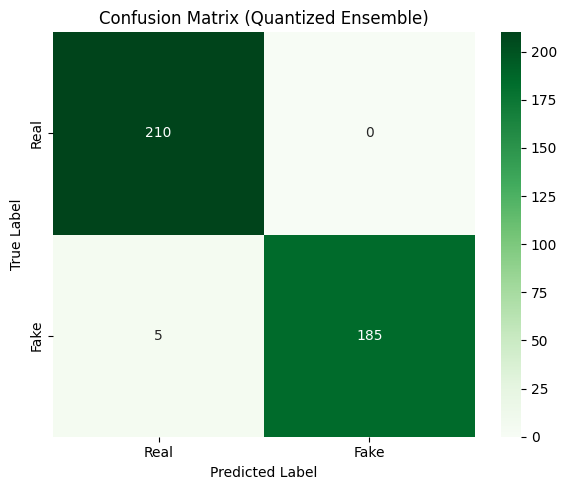

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms as T
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# --- CONFIGURATION ---
# Explicitly define the local path
LOCAL_DIR = '/content/local_data'

# --- HELPER: LOCAL EXTRACTION ---
def extract_features_local(split_name, model, root_dir):
    """
    Extracts features specifically from the local disk for speed.
    """
    model.eval()

    # Construct path: /content/local_data/train
    dataset_path = os.path.join(root_dir, split_name)

    # Safety Check
    if not os.path.exists(dataset_path):
        print(f"Error: Local path {dataset_path} not found.")
        return np.array([]), np.array([])

    print(f"Extracting features from: {dataset_path}")
    all_images = glob.glob(os.path.join(dataset_path, '*/*.jpg'))

    # Transform (Must match training!)
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    video_features = {}
    video_labels = {}

    with torch.no_grad():
        for img_path in tqdm(all_images, desc=f"Processing {split_name}"):
            try:
                # Metadata
                parent = os.path.basename(os.path.dirname(img_path))
                label = 0 if parent == 'real' else 1
                vid_name = os.path.basename(img_path).rsplit('_', 1)[0]

                # Load & Transform
                img = Image.open(img_path).convert('RGB')
                img_t = transform(img).unsqueeze(0).to(device)

                # Extract (Features are the 2nd return value)
                _, feat_512 = model(img_t)
                feat_np = feat_512.cpu().numpy().flatten()

                # Store
                if vid_name not in video_features:
                    video_features[vid_name] = []
                    video_labels[vid_name] = label
                video_features[vid_name].append(feat_np)
            except Exception as e:
                pass

    # Aggregate (Mean)
    X, y = [], []
    for vid, feats in video_features.items():
        X.append(np.mean(feats, axis=0))
        y.append(video_labels[vid])

    return np.array(X), np.array(y)


# --- CORRECTION: SWITCH TO CPU & LOCAL DATA ---

# 1. Force the global device to CPU
# Quantized PyTorch models (Int8) generally require CPU execution.
device = torch.device("cpu")
print(f"Switched processing device to: {device}")

# 2. Ensure the model is on CPU
q_model = q_model.to(device)

print("\nStarting Feature Extraction with PARTIAL Quantized Model (on CPU)...")

# 3. Run extraction (Using LOCAL_DIR)
X_train_q, y_train_q = extract_features_local('train', q_model, LOCAL_DIR)
X_val_q, y_val_q = extract_features_local('val', q_model, LOCAL_DIR)

print(f"Extraction Complete.")
print(f"Train Vectors: {X_train_q.shape}")
print(f"Val Vectors:   {X_val_q.shape}")

# 4. Re-Train Ensemble
print("\n--- Re-Training Ensemble on Mixed-Precision Features ---")
q_clfs = {
    'SVM': SVC(probability=True, kernel='rbf'),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'NB': GaussianNB()
}

preds_stack_q = []
for name, clf in q_clfs.items():
    clf.fit(X_train_q, y_train_q)
    p = clf.predict(X_val_q)
    preds_stack_q.append(p)
    acc = accuracy_score(y_val_q, p)
    print(f"{name} Accuracy: {acc*100:.2f}%")

# 5. Ensemble Vote
preds_stack_q = np.array(preds_stack_q)
votes_q = preds_stack_q.sum(axis=0)
ensemble_pred_q = (votes_q >= 2).astype(int)

# 6. Metrics & Visualization
print(f"\nFinal Partial-Quantized Ensemble Accuracy: {accuracy_score(y_val_q, ensemble_pred_q)*100:.2f}%")
print(classification_report(y_val_q, ensemble_pred_q, target_names=['Real', 'Fake']))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val_q, ensemble_pred_q)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix (Quantized Ensemble)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## B4. Compare the Sizes

In [ ]:
import os

def print_model_size(model, name):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    print(f"{name}: {size_mb:.2f} MB")
    os.remove("temp.p")

print("--- Size Comparison ---")
# Assuming 'model' is your original Float32 model
# Assuming 'q_model' is your Partial Quantized model
print_model_size(model, "Original (Float32)")
print_model_size(q_model, "Partial Quantized (Mixed)")

--- Size Comparison ---
Original (Float32): 46.74 MB
Partial Quantized (Mixed): 44.19 MB


## B5. Save the Quantized Model

In [ ]:
import os
import torch

# Define save location
save_dir = os.path.join(DATA_ROOT, 'trained_cnn')
os.makedirs(save_dir, exist_ok=True)

# Define filename
model_name = "quantized-0.94.pth"
save_path = os.path.join(save_dir, model_name)

# Save the model weights (state_dict is preferred over saving the whole object)
torch.save(q_model.state_dict(), save_path)

print(f"Model successfully saved to: {save_path}")

Model successfully saved to: /content/drive/My Drive/Deep Fake Dataset/trained_cnn/quantized-0.94.pth


# C. Replacing EfficientNet with ResNet with the DeepFake Dataset


## C1. Define the New CNN

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class DeepFakeResNet18(nn.Module):
    def __init__(self):
        super(DeepFakeResNet18, self).__init__()

        # 1. Load ResNet-18
        # Natively uses ReLU, so we don't need to hack the activation functions.
        # It is ~11 Million parameters (lightweight).
        self.backbone = models.resnet18(pretrained=True)

        # ResNet-18's final fully connected layer is named 'fc' and has 512 inputs.
        num_features = self.backbone.fc.in_features # 512

        # Remove the original ImageNet classifier
        self.backbone.fc = nn.Identity()

        # 2. Custom Head
        # We add this to maintain your requirement for a 512-dim latent vector
        # that can be extracted later for the ensemble.
        self.dense_512 = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Binary Classifier (Real vs Fake)
        self.classifier = nn.Linear(512, 2)

    def forward(self, x):
        x = self.backbone(x)         # Output: 512 (from ResNet pool)
        feat_512 = self.dense_512(x) # Output: 512 (Latent features for Ensemble)
        out = self.classifier(feat_512)
        return out, feat_512

## C2. Train the Model

In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm

# --- CONFIGURATION ---
SOURCE_DIR_DRIVE = os.path.join(DATA_ROOT, 'processed_faces') # Drive Location
LOCAL_DIR = '/content/local_data'                             # Colab Local Disk
EPOCHS = 15
LEARNING_RATE = 0.001
SAVE_PATH = os.path.join(DATA_ROOT, 'trained_cnn', 'resnet18_deepfake_v1.pth')

# ==========================================
# PART 1: COPY DATA TO LOCAL DISK
# ==========================================
def copy_data_to_local():
    # Only copy if we haven't already
    if os.path.exists(os.path.join(LOCAL_DIR, 'train')):
        print("Data already exists locally. Skipping copy.")
        return

    print(f"Copying data from {SOURCE_DIR_DRIVE} to {LOCAL_DIR}...")

    # We only need to copy the 'train' folder for training.
    # Validation can stay on Drive if you want, or copy both.
    # Here we copy everything inside 'processed_faces'.

    files_to_copy = []
    for root, dirs, files in os.walk(SOURCE_DIR_DRIVE):
        rel_path = os.path.relpath(root, SOURCE_DIR_DRIVE)
        dest_path = os.path.join(LOCAL_DIR, rel_path)
        os.makedirs(dest_path, exist_ok=True)
        for f in files:
            files_to_copy.append((os.path.join(root, f), os.path.join(dest_path, f)))

    # Execute Copy with Progress Bar
    for src, dst in tqdm(files_to_copy, desc="Copying Files", unit="file"):
        shutil.copy2(src, dst)

    print("Copy complete! Data is ready on local disk.")

# Run the copy
copy_data_to_local()


# ==========================================
# PART 2: MODEL DEFINITION (ResNet-18)
# ==========================================
class DeepFakeResNet18(nn.Module):
    def __init__(self):
        super(DeepFakeResNet18, self).__init__()
        # Load Pretrained ResNet-18
        self.backbone = models.resnet18(pretrained=True)

        # Get input size of the original fc layer (512 for ResNet18)
        num_features = self.backbone.fc.in_features

        # Remove original classifier
        self.backbone.fc = nn.Identity()

        # Custom Head (Latent Features -> Classifier)
        self.dense_512 = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Linear(512, 2)

    def forward(self, x):
        x = self.backbone(x)
        feat_512 = self.dense_512(x)
        out = self.classifier(feat_512)
        return out, feat_512


# ==========================================
# PART 3: TRAINING LOOP
# ==========================================

# 1. Setup Loaders
# Point to the local directory we just populated
TRAIN_DIR_LOCAL = os.path.join(LOCAL_DIR, 'train')

train_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print(f"Loading training data from: {TRAIN_DIR_LOCAL}")
train_dataset = ImageFolder(TRAIN_DIR_LOCAL, transform=train_tf)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

# 2. Setup Device & Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Active Device: {device}")

model = DeepFakeResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 3. Train
print(f"Starting ResNet-18 Training for {EPOCHS} epochs...")
model.train()

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Live Update
        acc = 100 * correct / total
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.2f}%")

    # End of Epoch Summary
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1} Done. Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

# 4. Save
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
torch.save(model.state_dict(), SAVE_PATH)
print(f"Training Complete. ResNet-18 saved to: {SAVE_PATH}")

Copying data from /content/drive/My Drive/Deep Fake Dataset/processed_faces to /content/local_data...


Copying Files:   0%|          | 0/20000 [00:00<?, ?file/s]

Copy complete! Data is ready on local disk.
Loading training data from: /content/local_data/train
Active Device: cuda
Starting ResNet-18 Training for 15 epochs...


Epoch 1/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 Done. Loss: 0.1606 | Accuracy: 93.20%


Epoch 2/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 Done. Loss: 0.0717 | Accuracy: 97.47%


Epoch 3/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3 Done. Loss: 0.0520 | Accuracy: 98.15%


Epoch 4/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4 Done. Loss: 0.0364 | Accuracy: 98.65%


Epoch 5/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5 Done. Loss: 0.0378 | Accuracy: 98.63%


Epoch 6/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6 Done. Loss: 0.0276 | Accuracy: 98.96%


Epoch 7/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7 Done. Loss: 0.0200 | Accuracy: 99.24%


Epoch 8/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8 Done. Loss: 0.0182 | Accuracy: 99.46%


Epoch 9/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9 Done. Loss: 0.0230 | Accuracy: 99.14%


Epoch 10/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10 Done. Loss: 0.0148 | Accuracy: 99.50%


Epoch 11/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11 Done. Loss: 0.0264 | Accuracy: 99.14%


Epoch 12/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12 Done. Loss: 0.0175 | Accuracy: 99.45%


Epoch 13/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13 Done. Loss: 0.0137 | Accuracy: 99.51%


Epoch 14/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14 Done. Loss: 0.0117 | Accuracy: 99.56%


Epoch 15/15:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15 Done. Loss: 0.0127 | Accuracy: 99.58%
Training Complete. ResNet-18 saved to: /content/drive/My Drive/Deep Fake Dataset/trained_cnn/resnet18_deepfake_v1.pth


## C3. Evaluate the Pure NN Performance

Just an experiment to see how the model performs without evaluation.

Loading weights from /content/drive/My Drive/Deep Fake Dataset/trained_cnn/resnet18_deepfake_v1.pth...
Model loaded successfully.
Validation Set: 4000 images
Running inference on validation set...


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]


--- ResNet-18 Performance ---
Accuracy: 0.9738

Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.96      0.97      1900
        Fake       0.96      0.99      0.98      2100

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



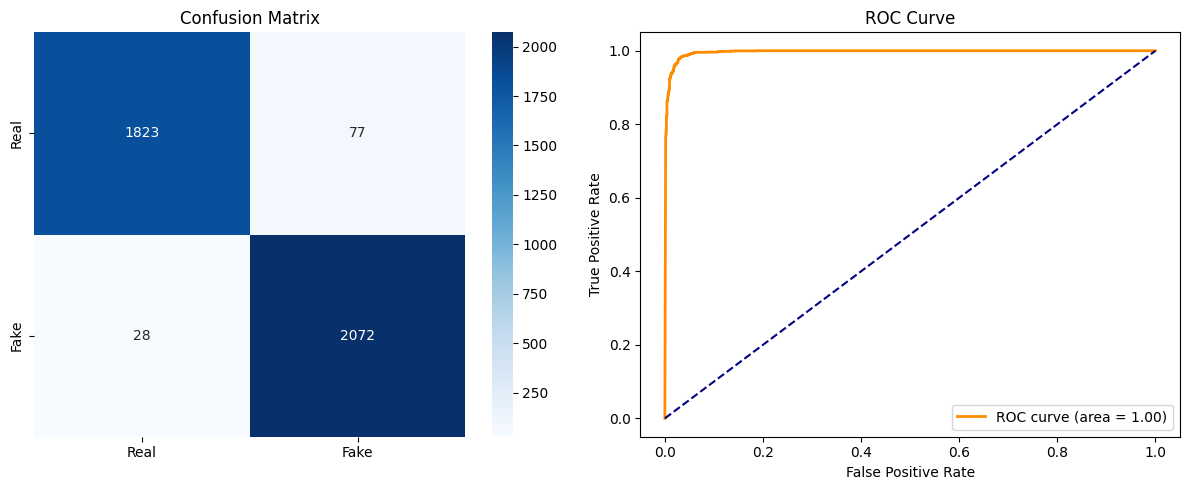

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm.auto import tqdm

# --- CONFIGURATION ---
SAVE_PATH = os.path.join(DATA_ROOT, 'trained_cnn', 'resnet18_deepfake_v1.pth')
VAL_DIR = os.path.join(DATA_ROOT, 'processed_faces', 'val')
BATCH_SIZE = 32

# 1. Initialize Model Architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeResNet18().to(device)

# 2. Load Weights
if os.path.exists(SAVE_PATH):
    print(f"Loading weights from {SAVE_PATH}...")
    model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
    model.eval()
    print("Model loaded successfully.")
else:
    raise FileNotFoundError(f"Checkpoint not found at {SAVE_PATH}")

# 3. Setup Validation Data
val_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

if os.path.exists(VAL_DIR):
    val_dataset = ImageFolder(VAL_DIR, transform=val_tf)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"Validation Set: {len(val_dataset)} images")
else:
    print(f"Error: {VAL_DIR} not found.")
    val_loader = None

# 4. Run Inference
if val_loader:
    y_true, y_pred, y_probs = [], [], []

    print("Running inference on validation set...")
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            logits, _ = model(inputs) # Ignore features for now

            probs = torch.softmax(logits, dim=1)
            _, preds = torch.max(logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy()[:, 1])

    # 5. Metrics & Plotting
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n--- ResNet-18 Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

    plt.figure(figsize=(12, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')

    # ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

## C4. Train and Evaluate the Ensemble Classifiers

--- 1. Feature Extraction ---
Extracting features from: /content/local_data/train


Processing train:   0%|          | 0/16000 [00:00<?, ?it/s]

Extracting features from: /content/local_data/val


Processing val:   0%|          | 0/4000 [00:00<?, ?it/s]

Train Features: (1600, 512)
Val Features:   (400, 512)

--- 2. Train Ensemble ---
SVM Accuracy: 99.00%
DT Accuracy: 98.75%
KNN Accuracy: 99.00%
NB Accuracy: 97.75%

--- 3. Ensemble Result (Max Voting) ---
Ensemble Accuracy: 99.00%
              precision    recall  f1-score   support

        Real       0.99      1.00      0.99       210
        Fake       0.99      0.98      0.99       190

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



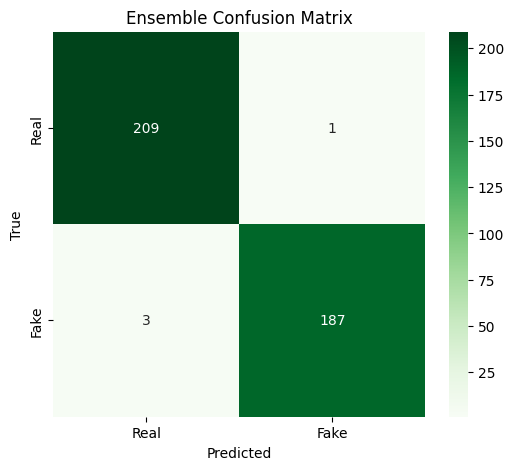

In [ ]:
import glob
from PIL import Image
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

def extract_features(split_name, model, local_root='/content/local_data'):
    """
    Extracts features from ResNet-18.
    Tries local disk first, falls back to Drive.
    """
    model.eval()

    # Determine path
    dataset_path = os.path.join(local_root, split_name)
    if not os.path.exists(dataset_path):
        print(f"Local path {dataset_path} not found. Using Drive...")
        dataset_path = os.path.join(DATA_ROOT, 'processed_faces', split_name)

    print(f"Extracting features from: {dataset_path}")
    all_images = glob.glob(os.path.join(dataset_path, '*/*.jpg'))

    if not all_images:
        print("No images found.")
        return np.array([]), np.array([])

    # Transform must match training
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    video_features = {}
    video_labels = {}

    with torch.no_grad():
        for img_path in tqdm(all_images, desc=f"Processing {split_name}"):
            try:
                # Metadata
                parent = os.path.basename(os.path.dirname(img_path))
                label = 0 if parent == 'real' else 1
                vid_name = os.path.basename(img_path).rsplit('_', 1)[0]

                # Load
                img = Image.open(img_path).convert('RGB')
                img_t = transform(img).unsqueeze(0).to(device)

                # Extract Feature (Second return value)
                _, feat_512 = model(img_t)
                feat_np = feat_512.cpu().numpy().flatten()

                # Store
                if vid_name not in video_features:
                    video_features[vid_name] = []
                    video_labels[vid_name] = label
                video_features[vid_name].append(feat_np)
            except Exception as e:
                pass

    # Aggregate (Mean pooling)
    X, y = [], []
    for vid, feats in video_features.items():
        X.append(np.mean(feats, axis=0))
        y.append(video_labels[vid])

    return np.array(X), np.array(y)

# --- EXECUTION ---
print("--- 1. Feature Extraction ---")
X_train, y_train = extract_features('train', model) # Uses Local if available
X_val, y_val = extract_features('val', model)       # Likely uses Drive (unless copied)

print(f"Train Features: {X_train.shape}")
print(f"Val Features:   {X_val.shape}")

print("\n--- 2. Train Ensemble ---")
clfs = {
    'SVM': SVC(probability=True, kernel='rbf'),
    'DT': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'NB': GaussianNB()
}

preds_stack = []
for name, clf in clfs.items():
    clf.fit(X_train, y_train)
    p = clf.predict(X_val)
    preds_stack.append(p)
    acc = accuracy_score(y_val, p)
    print(f"{name} Accuracy: {acc*100:.2f}%")

print("\n--- 3. Ensemble Result (Max Voting) ---")
# If >= 2 models say "Fake" (1), then prediction is Fake
votes = np.array(preds_stack).sum(axis=0)
ensemble_pred = (votes >= 2).astype(int)

ens_acc = accuracy_score(y_val, ensemble_pred)
print(f"Ensemble Accuracy: {ens_acc*100:.2f}%")
print(classification_report(y_val, ensemble_pred, target_names=['Real', 'Fake']))

# Plot Ensemble Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, ensemble_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Ensemble Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# D. Replacing EfficientNet with ResNet with the LAV-DF Dataset



## D1. Define the New CNN Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class DeepFakeResNet18(nn.Module):
    def __init__(self):
        super(DeepFakeResNet18, self).__init__()

        # 1. Load ResNet-18
        # Natively uses ReLU, so we don't need to hack the activation functions.
        # It is ~11 Million parameters (lightweight).
        self.backbone = models.resnet18(pretrained=True)

        # ResNet-18's final fully connected layer is named 'fc' and has 512 inputs.
        num_features = self.backbone.fc.in_features # 512

        # Remove the original ImageNet classifier
        self.backbone.fc = nn.Identity()

        # 2. Custom Head
        # We add this to maintain your requirement for a 512-dim latent vector
        # that can be extracted later for the ensemble.
        self.dense_512 = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Binary Classifier (Real vs Fake)
        self.classifier = nn.Linear(512, 2)

    def forward(self, x):
        x = self.backbone(x)         # Output: 512 (from ResNet pool)
        feat_512 = self.dense_512(x) # Output: 512 (Latent features for Ensemble)
        out = self.classifier(feat_512)
        return out, feat_512

### Copy all the faces to Colab

## D2. Train the CNN

In [ ]:
!cp -r "/content/drive/My Drive/Deep Fake Dataset/all.zip" "/content/"

In [ ]:
!unzip /content/all.zip -d /content/all_unzipped

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.auto import tqdm

# --- CONFIGURATION ---
TRAIN_DIR_LOCAL = '/content/all_unzipped'
EPOCHS = 30
LEARNING_RATE = 0.001
SAVE_PATH = os.path.join(DATA_ROOT, 'trained_cnn', 'resnet18_lav_df.pth')

# ==========================================
# 1. CUSTOM DATASET CLASS (Respects CSV Split)
# ==========================================
class DeepFakeFrameDataset(Dataset):
    def __init__(self, video_list, image_dir, transform=None):
        """
        video_list: List of tuples (video_path, label) from your CSV split logic.
        image_dir: The local directory where frames are stored (/content/all).
        """
        self.transform = transform
        self.samples = []

        print(f"Indexing frames for {len(video_list)} videos...")

        # 1. Scan the image_dir once to get all available frames
        # This is faster than globbing for every single video
        # We assume frames are named like: videoName_frameNum.jpg
        all_frames = glob.glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True)

        # Create a lookup dict: { 'video_name': [path_to_frame1, path_to_frame2, ...] }
        frame_lookup = {}
        for f_path in all_frames:
            filename = os.path.basename(f_path)
            # Logic: "myvideo_0.jpg" -> video_id = "myvideo"
            # We assume the frame suffix is separated by the LAST underscore
            if '_' in filename:
                vid_id = filename.rsplit('_', 1)[0]
                if vid_id not in frame_lookup:
                    frame_lookup[vid_id] = []
                frame_lookup[vid_id].append(f_path)

        # 2. Match CSV videos to Frames
        for vid_path, label in video_list:
            # Extract video ID from the full CSV path
            vid_id = os.path.splitext(os.path.basename(vid_path))[0]

            if vid_id in frame_lookup:
                # Add all frames for this video to our dataset
                for frame_path in frame_lookup[vid_id]:
                    self.samples.append((frame_path, label))

        print(f"Found {len(self.samples)} frames matching the provided video list.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# ==========================================
# 2. SETUP & TRAINING
# ==========================================

# Define Transforms
train_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize Dataset with YOUR 'train_videos' list
# Note: 'train_videos' must exist in memory from your previous code block
train_dataset = DeepFakeFrameDataset(
    video_list=train_videos,
    image_dir=TRAIN_DIR_LOCAL,
    transform=train_tf
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

# Setup Device & Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeResNet18().to(device) # Assumes class is defined
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Loop
print(f"Starting ResNet-18 Training on LAV-DF (CSV Split) for {EPOCHS} epochs...")
model.train()

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.2f}%")

    print(f"Epoch {epoch+1} Done. Loss: {running_loss/len(train_loader):.4f} | Accuracy: {100*correct/total:.2f}%")

# Save
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
torch.save(model.state_dict(), SAVE_PATH)
print(f"Training Complete. Saved to: {SAVE_PATH}")

Indexing frames for 1984 videos...
Found 18112 frames matching the provided video list.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]


Starting ResNet-18 Training on LAV-DF (CSV Split) for 30 epochs...


Epoch 1/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 1 Done. Loss: 0.3441 | Accuracy: 84.28%


Epoch 2/30:   0%|          | 0/283 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
         if w.is_alive(): 
  ^ ^ ^ ^^  ^^ ^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ 
   File "/usr/lib/pyth

Epoch 2 Done. Loss: 0.1810 | Accuracy: 92.83%


Epoch 3/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 3 Done. Loss: 0.1364 | Accuracy: 94.90%


Epoch 4/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 4 Done. Loss: 0.1140 | Accuracy: 95.71%


Epoch 5/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 5 Done. Loss: 0.0836 | Accuracy: 96.86%


Epoch 6/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 6 Done. Loss: 0.0753 | Accuracy: 97.39%


Epoch 7/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 7 Done. Loss: 0.0544 | Accuracy: 98.14%


Epoch 8/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 8 Done. Loss: 0.0601 | Accuracy: 97.88%


Epoch 9/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 9 Done. Loss: 0.0458 | Accuracy: 98.28%


Epoch 10/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 10 Done. Loss: 0.0480 | Accuracy: 98.19%


Epoch 11/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 11 Done. Loss: 0.0397 | Accuracy: 98.53%


Epoch 12/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 12 Done. Loss: 0.0354 | Accuracy: 98.65%


Epoch 13/30:   0%|          | 0/283 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 13 Done. Loss: 0.0335 | Accuracy: 98.81%


Epoch 14/30:   0%|          | 0/283 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: 
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>self._shutdown_workers()
    
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

         if

Epoch 14 Done. Loss: 0.0323 | Accuracy: 98.96%


Epoch 15/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 15 Done. Loss: 0.0266 | Accuracy: 99.09%


Epoch 16/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 16 Done. Loss: 0.0288 | Accuracy: 99.00%


Epoch 17/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 17 Done. Loss: 0.0291 | Accuracy: 98.97%


Epoch 18/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 18 Done. Loss: 0.0245 | Accuracy: 99.13%


Epoch 19/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 19 Done. Loss: 0.0251 | Accuracy: 99.13%


Epoch 20/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 20 Done. Loss: 0.0250 | Accuracy: 99.13%


Epoch 21/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 21 Done. Loss: 0.0199 | Accuracy: 99.32%


Epoch 22/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 22 Done. Loss: 0.0258 | Accuracy: 99.18%


Epoch 23/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 23 Done. Loss: 0.0213 | Accuracy: 99.28%


Epoch 24/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 24 Done. Loss: 0.0203 | Accuracy: 99.32%


Epoch 25/30:   0%|          | 0/283 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    
if w.is_alive():  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

     assert self._parent_pid == os.getpid(), 'can only test a child process' 
           ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^
  Fi

Epoch 25 Done. Loss: 0.0204 | Accuracy: 99.29%


Epoch 26/30:   0%|          | 0/283 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():
self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
     ^ ^ ^Exception ignored in:  ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x78f0217aafc0>^^
^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dat

Epoch 26 Done. Loss: 0.0145 | Accuracy: 99.43%


Epoch 27/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 27 Done. Loss: 0.0131 | Accuracy: 99.54%


Epoch 28/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 28 Done. Loss: 0.0154 | Accuracy: 99.41%


Epoch 29/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 29 Done. Loss: 0.0187 | Accuracy: 99.36%


Epoch 30/30:   0%|          | 0/283 [00:00<?, ?it/s]

Epoch 30 Done. Loss: 0.0122 | Accuracy: 99.51%
Training Complete. Saved to: /content/drive/My Drive/Deep Fake Dataset/trained_cnn/resnet18_lav_df.pth


## D3. Evaluate the Pure NN Performance

Loading weights from /content/drive/My Drive/Deep Fake Dataset/trained_cnn/resnet18_lav_df.pth...
Model loaded successfully.
Indexing frames for 1984 videos...
Found 17874 frames matching the provided video list.
Running inference on validation set...


Evaluating:   0%|          | 0/559 [00:00<?, ?it/s]


--- ResNet-18 Performance ---
Accuracy: 0.9399

Classification Report:
              precision    recall  f1-score   support

        Real       0.93      0.96      0.94      9653
        Fake       0.95      0.92      0.93      8221

    accuracy                           0.94     17874
   macro avg       0.94      0.94      0.94     17874
weighted avg       0.94      0.94      0.94     17874



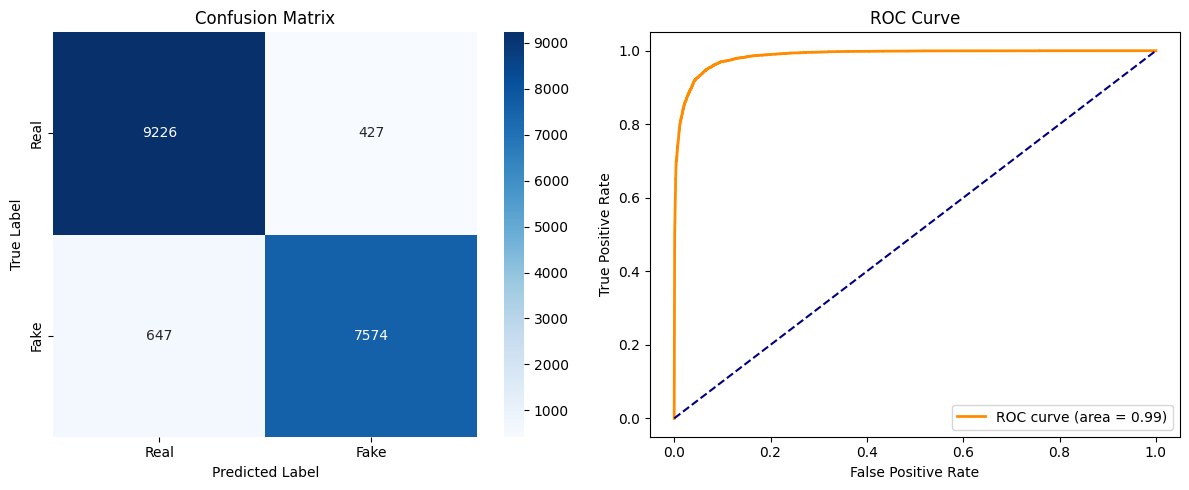

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm.auto import tqdm

# --- CONFIGURATION ---
SAVE_PATH = os.path.join(DATA_ROOT, 'trained_cnn', 'resnet18_lav_df.pth')
LOCAL_IMG_DIR = '/content/all_unzipped'
BATCH_SIZE = 32

# 1. Initialize Model Architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepFakeResNet18().to(device)

# 2. Load Weights
if os.path.exists(SAVE_PATH):
    print(f"Loading weights from {SAVE_PATH}...")
    model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
    model.eval()
    print("Model loaded successfully.")
else:
    raise FileNotFoundError(f"Checkpoint not found at {SAVE_PATH}")

# 3. Setup Validation Data (Using CSV List)
# Note: This relies on 'val_videos' and 'DeepFakeFrameDataset' being defined in your previous cells
val_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

if 'val_videos' in locals() and os.path.exists(LOCAL_IMG_DIR):
    val_dataset = DeepFakeFrameDataset(
        video_list=val_videos,
        image_dir=LOCAL_IMG_DIR,
        transform=val_tf
    )
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
else:
    print(f"Error: 'val_videos' list or directory {LOCAL_IMG_DIR} missing.")
    val_loader = None

# 4. Run Inference
if val_loader:
    y_true, y_pred, y_probs = [], [], []

    print("Running inference on validation set...")
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            logits, _ = model(inputs) # Ignore features for now

            probs = torch.softmax(logits, dim=1)
            _, preds = torch.max(logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy()[:, 1])

    # 5. Metrics & Plotting
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n--- ResNet-18 Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

    plt.figure(figsize=(12, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

## D4. Train and Evaluate the Ensemble Classifiers

--- 1. Feature Extraction ---
Extracting features for 1984 videos...
Indexing frames in /content/all_unzipped...


  0%|          | 0/1984 [00:00<?, ?it/s]

Extracting features for 1984 videos...
Indexing frames in /content/all_unzipped...


  0%|          | 0/1984 [00:00<?, ?it/s]

Train Features: (1920, 512)
Val Features:   (1917, 512)

--- 2. Train Ensemble ---
SVM Accuracy: 97.50%
DT Accuracy: 96.56%
KNN Accuracy: 97.29%
NB Accuracy: 95.72%

--- 3. Ensemble Result (Max Voting) ---
Ensemble Accuracy: 96.82%
              precision    recall  f1-score   support

        Real       0.98      0.96      0.97      1033
        Fake       0.95      0.98      0.97       884

    accuracy                           0.97      1917
   macro avg       0.97      0.97      0.97      1917
weighted avg       0.97      0.97      0.97      1917



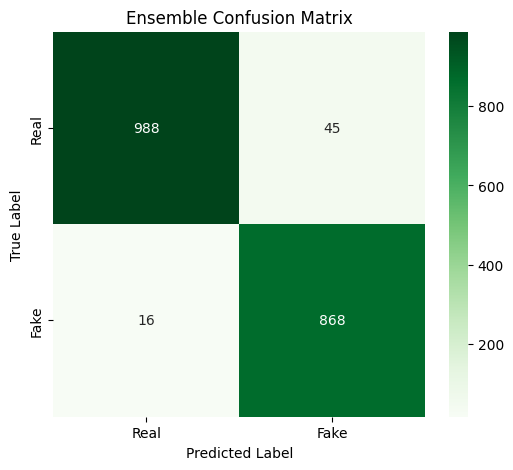

In [ ]:
import glob
from PIL import Image
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

def extract_features_from_list(video_list, model, local_img_dir='/content/all_unzipped'):
    """
    Extracts features for a specific list of videos (from CSV split).
    Scans local_img_dir once to map video_ids to frame paths.
    """
    model.eval()
    print(f"Extracting features for {len(video_list)} videos...")

    # 1. Pre-scan directory to build a lookup map (Optimization)
    # This avoids calling glob() thousands of times
    print(f"Indexing frames in {local_img_dir}...")
    all_frames = glob.glob(os.path.join(local_img_dir, '**', '*.jpg'), recursive=True)
    frame_lookup = {}

    for f_path in all_frames:
        filename = os.path.basename(f_path)
        # "videoID_frameX.jpg" -> "videoID"
        if '_' in filename:
            vid_id = filename.rsplit('_', 1)[0]
            if vid_id not in frame_lookup:
                frame_lookup[vid_id] = []
            frame_lookup[vid_id].append(f_path)

    # Transform
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    final_X = []
    final_y = []

    # 2. Process Videos
    with torch.no_grad():
        for vid_path, label in tqdm(video_list):
            vid_id = os.path.splitext(os.path.basename(vid_path))[0]

            if vid_id in frame_lookup:
                video_frames = frame_lookup[vid_id]
                batch_feats = []

                for img_path in video_frames:
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img_t = transform(img).unsqueeze(0).to(device)

                        # Extract Feature (Second return value: feat_512)
                        _, feat_512 = model(img_t)
                        batch_feats.append(feat_512.cpu().numpy().flatten())
                    except:
                        continue

                # Aggregate (Mean Pooling per video)
                if batch_feats:
                    video_avg = np.mean(batch_feats, axis=0)
                    final_X.append(video_avg)
                    final_y.append(label)

    return np.array(final_X), np.array(final_y)

# --- EXECUTION ---
print("--- 1. Feature Extraction ---")
# Uses the lists 'train_videos' and 'val_videos' from your CSV split code
X_train, y_train = extract_features_from_list(train_videos, model)
X_val, y_val = extract_features_from_list(val_videos, model)

print(f"Train Features: {X_train.shape}")
print(f"Val Features:   {X_val.shape}")

print("\n--- 2. Train Ensemble ---")
clfs = {
    'SVM': SVC(probability=True, kernel='rbf'),
    'DT': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'NB': GaussianNB()
}

preds_stack = []
for name, clf in clfs.items():
    clf.fit(X_train, y_train)
    p = clf.predict(X_val)
    preds_stack.append(p)
    acc = accuracy_score(y_val, p)
    print(f"{name} Accuracy: {acc*100:.2f}%")

print("\n--- 3. Ensemble Result (Max Voting) ---")
# If >= 2 models say "Fake" (1), then prediction is Fake
votes = np.array(preds_stack).sum(axis=0)
ensemble_pred = (votes >= 2).astype(int)

ens_acc = accuracy_score(y_val, ensemble_pred)
print(f"Ensemble Accuracy: {ens_acc*100:.2f}%")
print(classification_report(y_val, ensemble_pred, target_names=['Real', 'Fake']))

# Plot Ensemble Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, ensemble_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Ensemble Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()